In [1]:
import os
import pandas as pd
import numpy as np
import cv2   
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import urllib.request
from urllib.error import HTTPError

import sys

#if sys.version_info[0] == 3:
#    from urllib.request import urlopen
#else:
    # Not Python 3 - today, it is most likely to be Python 2
    # But note that this might need an update when Python 4
    # might be around one day
#    from urllib import urlopen

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
from sklearn.utils import shuffle
import math

plt.style.use('ggplot')

%matplotlib inline

import tensorflow as tf
print(tf.__version__)

IMG_WIDTH = 182
IMG_HEIGHT = 268
BATCH_SIZE = 16
NUM_EPOCHS = 20

Using TensorFlow backend.


1.13.1


In [2]:
os.chdir("C:/Users/benja/Desktop/comp562")
print(os.getcwd())
main_folder = 'movie-genre-from-its-poster/'
images_folder = main_folder + 'SampleMoviePosters/SampleMoviePosters/'
images_folder_no_ending = main_folder + 'SampleMoviePosters/SampleMoviePosters'

C:\Users\benja\Desktop\comp562


In [3]:
# import the data set that include the attribute for each picture
#df_attr = pd.read_csv(main_folder + 'MovieGenre.csv')
#df_attr = pd.read_csv('movie-genre-from-its-poster/MovieGenre.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv(main_folder + 'MovieGenre.csv', encoding="ISO-8859-1", usecols=["imdbId", "Title", "Genre", "Poster"])
df_attr.set_index(["imdbId"], inplace=True)
df_attr.dropna(inplace=True)

df_attr.drop_duplicates(subset="Poster", keep=False, inplace=True)

df_attr.shape
df_attr.head(n=15)

,Title,Genre,Poster
imdbId,,,
114709,Toy Story (1995),Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
113497,Jumanji (1995),Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
113228,Grumpier Old Men (1995),Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
114885,Waiting to Exhale (1995),Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
113041,Father of the Bride Part II (1995),Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...
113277,Heat (1995),Action|Crime|Drama,https://images-na.ssl-images-amazon.com/images...
114319,Sabrina (1995),Comedy|Drama,https://images-na.ssl-images-amazon.com/images...
112302,Tom and Huck (1995),Adventure|Comedy|Drama,https://images-na.ssl-images-amazon.com/images...
114576,Sudden Death (1995),Action|Crime|Thriller,https://images-na.ssl-images-amazon.com/images...


In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10599310628390487396
]


[]

In [5]:
#initial thing to try is classifying action vs non-action movie
#first create a column that is binary data for action or non action where 1 is that it is action
def is_action(r):
    return 1 if (r['Genre'].find("Horror") != -1)  else 0 
df_attr['isHorror'] = df_attr.apply (lambda row: is_action(row), axis=1)


In [6]:
#we need 3 sets: train, validation, test
#first look at the split of data
print(df_attr[df_attr['isHorror'] == 1].shape)
print(df_attr[df_attr['isHorror'] == 0].shape)
#since these sets are uneven, we need to make sure to sample even amounts.
#the split will be 70% train, 15% validation, 15% test


(3861, 4)
(33989, 4)


In [7]:
np.random.seed(23)

def generate_sets(df, columnName):
    df_one = df[df[columnName] == 1]
    df_zero = df[df[columnName] == 0]
                      
    #make the assumption for now that the set of ones is smaller than the set of zero, we want an approximately equal amount of both
    df_zero = df_zero.sample(n=df_one.shape[0])
    
    total_df = pd.concat([df_one, df_zero])
    
    total_df = shuffle(total_df, random_state=1)
    total_rows = total_df.shape[0]
    
    train_end_index = math.floor(total_rows * .7)
    validation_end_index = math.floor(total_rows * .15 + train_end_index)
    test_end_index = math.floor(total_rows * .15 + validation_end_index)
    
    train_set = total_df[0:train_end_index]
    validation_set = total_df[train_end_index+1:validation_end_index]
    test_set = total_df[validation_end_index+1:total_rows]
    
    return (train_set, validation_set, test_set)

train_set, validation_set, test_set = generate_sets(df_attr, 'isHorror')
TRAINING_SAMPLES = train_set.shape[0]
VALIDATION_SAMPLES = validation_set.shape[0]
TEST_SAMPLES = test_set.shape[0]

In [8]:
download=True
import os
def download_images(df):
    imgFileNames = []
    print(type(df))
    numFailed = 0
    numSucceeded = 0
    for index, row in df.iterrows():
        filePath = str(index)+'.jpg'
       
        exists = os.path.isfile(filePath)
        
        if download and not exists:
            try:
                urllib.request.urlretrieve(row['Poster'], filePath)    
                imgFileNames.append(filePath)
                numSucceeded = numSucceeded + 1
            except Exception as e:
                imgFileNames.append('failed404')
                numFailed = numFailed + 1
                pass
        else:
            try:
                fh = open(filePath, 'r')
                imgFileNames.append(filePath)
                numSucceeded = numSucceeded + 1
                fh.close()
            except FileNotFoundError:
                numFailed = numFailed + 1
                imgFileNames.append('failed404')
    print(str(numFailed) + 'failed')
    print(str(numSucceeded) + 'succeeded')
    imgFileNames = pd.Series(imgFileNames)
    #print(imgFileNames.head(n=7))
    #these few lines are to add filenames to the dataframe and then drop any that gave 404's
    df['filePath'] = imgFileNames.values
    df = df.replace('failed404', np.NaN)
    df = df.dropna() 
    #print(df.head())
    return df
    
                                               

train_set = download_images(train_set)
test_set = download_images(test_set)
validation_set = download_images(validation_set)

<class 'pandas.core.frame.DataFrame'>
197failed
5208succeeded
<class 'pandas.core.frame.DataFrame'>
29failed
1129succeeded
<class 'pandas.core.frame.DataFrame'>
48failed
1109succeeded


In [9]:
train_set.set_index(["filePath"], inplace=True)
test_set.set_index(["filePath"], inplace=True)
validation_set.set_index(["filePath"], inplace=True)

In [10]:
print(train_set.shape)
print(test_set.shape)
print(validation_set.shape)
train_set.head(n=12)

(5208, 4)
(1129, 4)
(1109, 4)


,Title,Genre,Poster,isHorror
filePath,,,,
116920.jpg,Losing Chase (1996),Drama,https://images-na.ssl-images-amazon.com/images...,0
2004432.jpg,Wolf Creek 2 (2013),Horror,https://images-na.ssl-images-amazon.com/images...,1
443335.jpg,Off the Charts: The Song-Poem Story (2003),Documentary,https://images-na.ssl-images-amazon.com/images...,0
195714.jpg,Final Destination (2000),Horror|Thriller,https://images-na.ssl-images-amazon.com/images...,1
107504.jpg,Man's Best Friend (1993),Comedy|Horror|Sci-Fi,https://images-na.ssl-images-amazon.com/images...,1
1567437.jpg,The Voices (2014),Comedy|Crime|Horror,https://images-na.ssl-images-amazon.com/images...,1
4935334.jpg,Southbound (2015),Fantasy|Horror|Thriller,https://images-na.ssl-images-amazon.com/images...,1
128292.jpg,KnoflÌ_kÌÁri (1997),Comedy,https://images-na.ssl-images-amazon.com/images...,0
88107.jpg,Saang gong kei bing (1984),Action|Crime|Thriller,https://images-na.ssl-images-amazon.com/images...,0


In [11]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

def setup_images(df_, partition, attr):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(str(fname)) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 268, 182, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(str(index))
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_


In [12]:
x_train, y_train = setup_images(train_set,0, 'isHorror')

In [13]:
x_train[1:5]

array([[[[0.15686275, 0.10196079, 0.06666667],
         [0.17254902, 0.11764706, 0.08235294],
         [0.14509805, 0.09019608, 0.05490196],
         ...,
         [0.34901962, 0.2901961 , 0.2627451 ],
         [0.3019608 , 0.24313726, 0.21568628],
         [0.20784314, 0.14901961, 0.12156863]],

        [[0.4627451 , 0.40784314, 0.37254903],
         [0.1764706 , 0.12156863, 0.08627451],
         [0.10980392, 0.05490196, 0.01960784],
         ...,
         [0.3529412 , 0.29411766, 0.26666668],
         [0.21176471, 0.15294118, 0.1254902 ],
         [0.17254902, 0.11372549, 0.08627451]],

        [[0.4627451 , 0.40784314, 0.37254903],
         [0.5411765 , 0.4862745 , 0.4509804 ],
         [0.53333336, 0.46666667, 0.43529412],
         ...,
         [0.43137255, 0.37254903, 0.34509805],
         [0.34901962, 0.2901961 , 0.2627451 ],
         [0.28627452, 0.22745098, 0.2       ]],

        ...,

        [[0.5764706 , 0.5411765 , 0.5137255 ],
         [0.36862746, 0.33333334, 0.30588236]

In [14]:
print(y_train[1:20])

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [15]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [16]:
x_valid, y_valid = setup_images(validation_set, 1, 'isHorror')
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)

In [17]:
inc_model = InceptionV3(weights='inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))

Instructions for updating:
Colocations handled automatically by placer.
number of layers: 311


In [18]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [20]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
338/337 [==============================] - 985s 3s/step - loss: 0.6943 - acc: 0.5514 - val_loss: 0.6492 - val_acc: 0.6195

Epoch 00001: val_loss improved from inf to 0.64924, saving model to weights.best.inc.male.hdf5
Epoch 2/20
338/337 [==============================] - 984s 3s/step - loss: 0.6429 - acc: 0.6372 - val_loss: 0.6240 - val_acc: 0.6501

Epoch 00002: val_loss improved from 0.64924 to 0.62402, saving model to weights.best.inc.male.hdf5
Epoch 3/20
338/337 [==============================] - 973s 3s/step - loss: 0.6187 - acc: 0.6699 - val_loss: 0.6009 - val_acc: 0.6745

Epoch 00003: val_loss improved from 0.62402 to 0.60090, saving model to weights.best.inc.male.hdf5
Epoch 4/20
338/337 [==============================] - 973s 3s/step - loss: 0.5916 - acc: 0.6910 - val_loss: 0.5743 - val_acc: 0.6988

Epoch 00004: val_loss improved from 0.60090 to 0.57430, saving model to weights.best.inc.male.hdf5
Epoch 5/20
338/337 [====

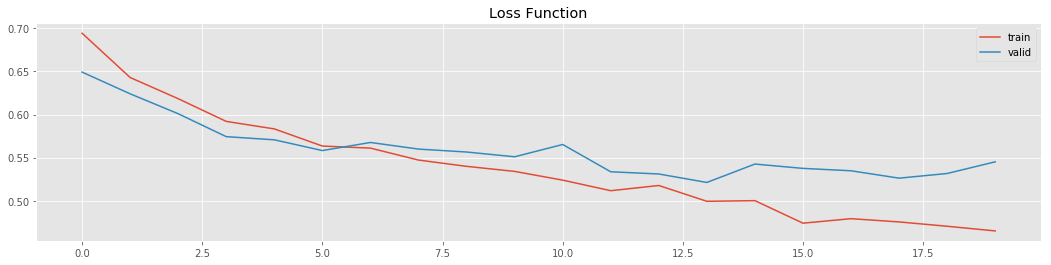

In [21]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

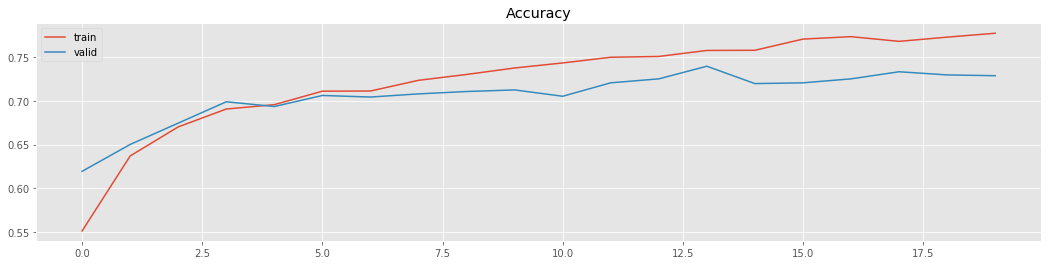

In [22]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [23]:
model_.load_weights('weights.best.inc.male.hdf5')

In [24]:
x_test, y_test =setup_images(test_set, 2, 'isHorror')

In [26]:
# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions, average='micro'))

Model Evaluation
Test accuracy: 74.9336%
f1_score: 0.7493356953055802
